In [1]:
import networkx as nx
import numpy as np

import os 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib import cm

import scipy.stats as ss
from scipy.io import mmread

import seaborn as sns
import pandas as pd

# ref: https://matplotlib.org/gallery/api/font_family_rc_sgskip.html
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams["mathtext.fontset"] = 'dejavusans'

# upper panel

In [5]:
datas = {celltype:mmread('../data/%s/matrix.mtx' % (celltype)).toarray() for celltype in ['cd14', 'b_cells', 'cd34', 'cd4']}
fullnames = {'cd14':'Monocytes', 'b_cells':'B cells', 'cd34':'CD34+ cells', 'cd4':'Helper T cells'}

In [9]:
def poisson_re_plot_main(celltype, ax, re=False):
    # load data
    exp_data = datas[celltype]
    sf = exp_data.sum(axis=0)/exp_data.sum(axis=0).mean()
    
    # remove genes with no expression
    exp_data = exp_data[exp_data.sum(axis=1)>0,:]
    
    # compute observed zero proportion
    true_zeros = (exp_data == 0).sum(axis=1) / exp_data.shape[1]
    z_sig = ss.norm.ppf(1-0.05/exp_data.shape[0])
    
    if re == False:
        # predicted zero proportion without random effects
        pred_zeros = np.exp(-exp_data.mean(axis=1))
                
    elif re == True:
        # predicted zero using monte-carlo integration
        log_sf_std = np.log(sf).std()
        n_sample = 500
        log_sf_samples = np.random.normal(0, log_sf_std, size=(exp_data.shape[0], n_sample))
        mu = exp_data.mean(axis=1) / np.exp((log_sf_std ** 2)/2)
        pred_zeros = np.exp(- mu[:,None] * np.exp(log_sf_samples)).mean(axis=1)
                                 
    # z_score 
    pred_zeros_std = np.sqrt(pred_zeros * (1-pred_zeros)/ exp_data.shape[0]) 
    z_score = (true_zeros - pred_zeros)/pred_zeros_std                       
                                 
    # scatterplot
    scatter = ax.scatter(y=true_zeros, x=pred_zeros, c=z_score, cmap='coolwarm')
    scatter.set_clim([-15,15])
    
    # error bar
    err_grid = np.linspace(0, 1, 50)
    err_width = np.sqrt(err_grid * (1-err_grid) / exp_data.shape[0]) * z_sig
    ax.plot(err_grid, err_grid, color='black', label='0%')
    ax.plot(err_grid, err_grid+err_width, color='red', linestyle='--', alpha=0.5, label='95%')
    ax.plot(err_grid, err_grid-err_width, color='blue', linestyle='--', alpha=0.5, label='5%')
    
    # legend
    lgd = ax.legend(loc='upper left', prop={'weight':'bold', 'size':13})
    lgd.get_frame().set_linewidth(0.0)
    
    # percentile absolute z-value and zero inflation proportion
    z_percentile = np.percentile(np.abs(z_score[~np.isnan(z_score)]), (99.9, 99.5, 99, 95, 50))
    ax.text(x=0.95, y=0.05, s=((fullnames[celltype])+'\n'+'$n$-th percentile\n Z-score\n 0.1%%: %.2f\n 0.5%%: %.2f\n 1%%: %.2f\n 5%%: %.2f\n 50%%: %.2f\n ' % tuple(z_percentile)), 
                 transform=ax.transAxes, ha='right', fontsize=17)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)
    
    return scatter

def poisson_re_plot(axes, re=False):
    celltypes = ['cd14', 'b_cells', 'cd34', 'cd4']
    scatters = []
    for ax, celltype in zip(axes, celltypes):
        scatters.append(poisson_re_plot_main(celltype, ax, re))
        
    # set log scale
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].set_xlim([1e-4, 1])
    axes[0].set_ylim([1e-4, 1])
    
    return scatters

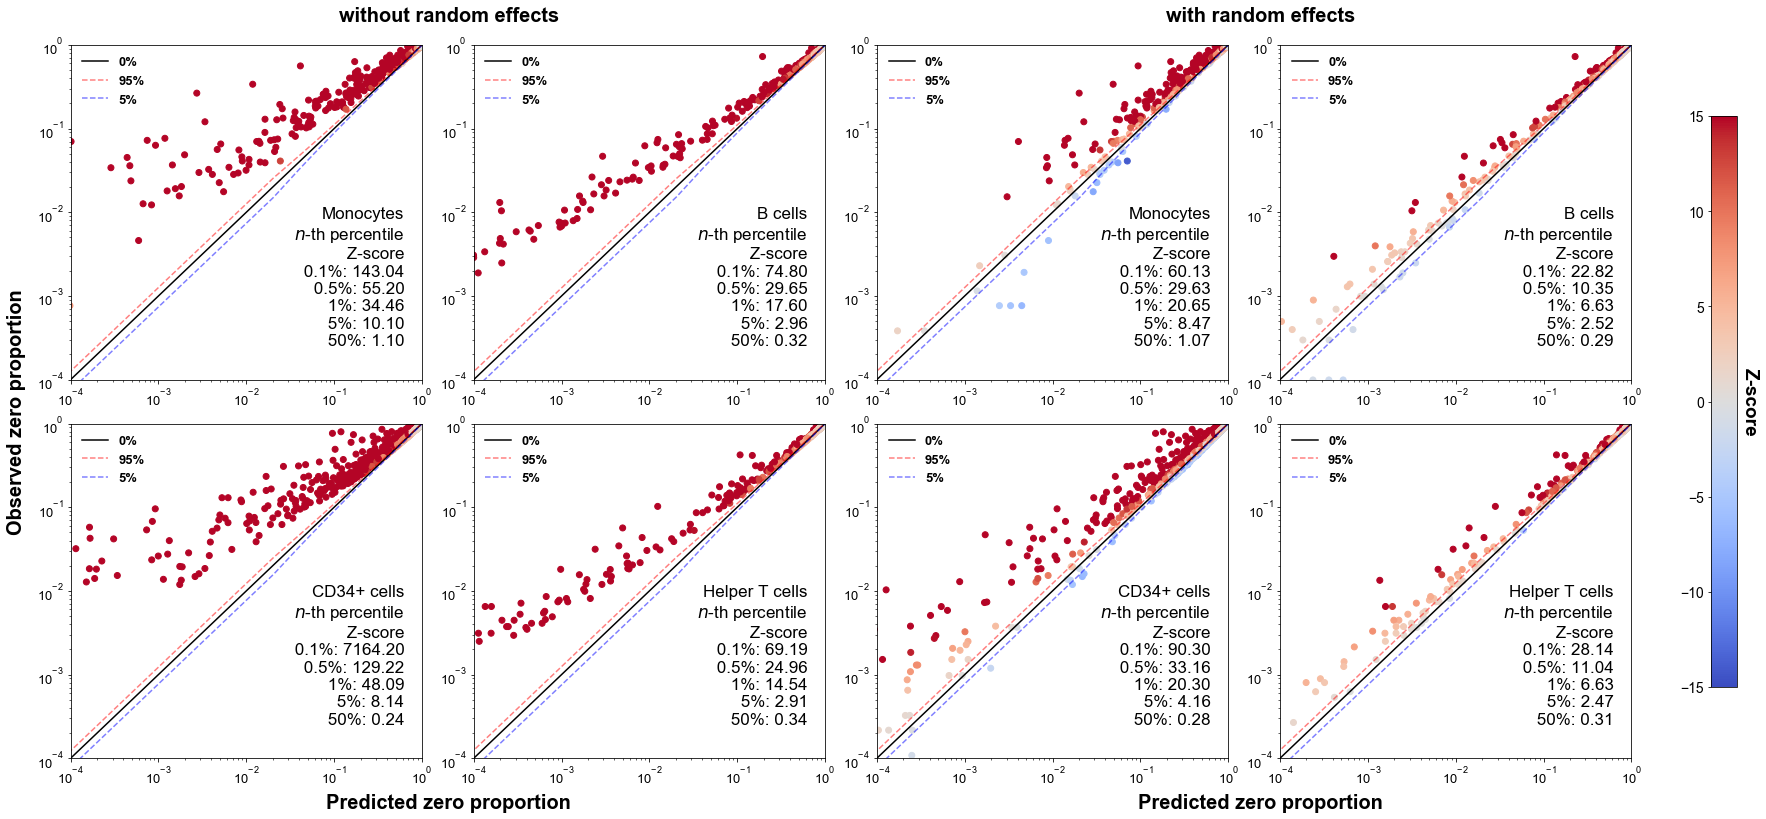

In [10]:
fig2 = plt.figure(figsize=(24, 10.5), constrained_layout=True) # 가로 세로
gs2 = fig2.add_gridspec(12, 24) # 행 렬

# fig1 : no size factor
fig2a = []
for i in range(4):
    x, y = int(i/2), i%2
    if i == 0:
        fig2a.append(fig2.add_subplot(gs2[6*x:6*(x+1),6*y:6*(y+1)]))
    else:
        fig2a.append(fig2.add_subplot(gs2[6*x:6*(x+1),6*y:6*(y+1)], sharex=fig2a[0], sharey=fig2a[0]))
    
# fig2 : with size factor
fig2b = []
for i in range(4):
    x, y = int(i/2), i%2
    if i == 0:
        fig2b.append(fig2.add_subplot(gs2[6*x:6*(x+1),6*y+12:6*(y+1)+12]))
    else:
        fig2b.append(fig2.add_subplot(gs2[6*x:6*(x+1),6*y+12:6*(y+1)+12], sharex=fig2b[0], sharey=fig2b[0]))
    
scattera = poisson_re_plot(fig2a, False)
scatterb = poisson_re_plot(fig2b, True)
cbar = fig2.colorbar(scattera[0], ax=fig2a+fig2b, shrink=0.8, aspect=40)
cbar.ax.set_ylabel('Z-score',
                       rotation=270,
                       fontsize=19,
                       fontweight='bold',
                       va='bottom'
                      )
cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), fontsize=20)
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.set_ticks_position('left')

fig2.text(-0.01, 0.5, 'Observed zero proportion', rotation=90, ha='center', va='center', fontsize=20, fontweight='bold')
fig2.text(0.24, -0.005, 'Predicted zero proportion', ha='center', va='top', fontsize=20, fontweight='bold')
fig2.text(0.71, -0.005, 'Predicted zero proportion', ha='center', va='top', fontsize=20, fontweight='bold')
fig2.text(0.24, 1.01, 'without random effects', ha='center', va='bottom', fontsize=20, fontweight='bold')
fig2.text(0.71, 1.01, 'with random effects', ha='center', va='bottom', fontsize=20, fontweight='bold')

plt.show()

# Lower panel

In [15]:
# brew colormap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

cmap_cont = LinearSegmentedColormap.from_list("gtor", ['grey', 'orange', 'red', 'red'])
cmap_cat = plt.get_cmap('Paired')

In [126]:
def figure2_mid(axes, ver, figno):
    tsne = pd.read_csv('%s/tsne_%s.csv' % (figno,ver), index_col=0)
    meta = pd.read_csv('%s/cluster_%s.csv' % (figno,ver), index_col=0)
    gene_data = pd.read_csv('%s/exprs.csv' % figno, index_col=0)
    meta.index = tsne.index
    gene_data.index = tsne.index
    
    #  ['dodgerblue', 'orange', 'limegreen', 'orangered', 'slateblue', 'hotpink', 'chocolate']
    if ver == 'sct':
        colors = ['dodgerblue', 'orange', 'limegreen', 'chocolate', 'slateblue', 'orangered', 'hotpink', 'cyan', 'slategrey']
    else:
        colors = ['dodgerblue', 'orangered', 'orange']
    
    
    sns.scatterplot(x='tSNE_1', y='tSNE_2', 
                    hue=meta['seurat_clusters'].astype(str),
                    data=tsne,
                    ax=axes[0],
                    palette=colors,
                    s=30,
                    edgecolor=None)
    
    handles, _ = axes[0].get_legend_handles_labels() 
    """
    """
    if ver == 'sct':
        handles_old = handles[:5] + handles[6:] + [handles[5]]
        axes[0].legend(handles=handles_old, labels=['','', '','', '', '','','CD14+ Monocytes','Dendritic cells'], loc='center right',
                       bbox_to_anchor=(1.2, 1),
                        fontsize=15, frameon=False, ncol=6, columnspacing=0, handletextpad=0.1)
    else:
        handles_new = [handles[2], handles[0], handles[1]] 
        axes[0].legend(handles=handles_new, labels=['','CD14+ Monocytes','Dendritic cells'], loc='center right',
                       bbox_to_anchor=(1.1, 1),
                        fontsize=15, frameon=False, ncol=3, columnspacing=0, handletextpad=0.1)
    

    sns.scatterplot(x='tSNE_1', y='tSNE_2',
                   hue=np.log(meta['nCount_RNA']),
                   data=tsne,
                   ax=axes[1],
                   palette=cmap_cont,
                   s=3)
    
        
    for ax in axes:
        ax.axis('off')
    
    genes = ['Count', 'CD14', 'CLEC9A', 'CLEC10A']
    for i, (ax, gene) in enumerate(zip(axes[2:], genes[1:])):
        sns.scatterplot(x='tSNE_1', y='tSNE_2',
                   hue=np.log(gene_data.loc[:,gene]+1e-1),
                   data=tsne,
                   ax=axes[i+2],
                   palette=cmap_cont,
                   s=2)
    
    for ax, gene in zip(axes[1:], genes):
        ax.text(0.9, 1, '%s' % gene.replace('.','-'), ha='right', va='bottom', transform=ax.transAxes, fontstyle='italic')
        ax.get_legend().remove()


In [157]:
def figure2_low(axes, ver, figno):
    tsne = pd.read_csv('%s/tsne_%s.csv' % (figno,ver), index_col=0)
    meta = pd.read_csv('%s/cluster_%s.csv' % (figno,ver), index_col=0)
    deg = pd.read_csv('%s/deg_%s.csv' % (figno, ver), index_col=0)
    celltype = pd.read_csv('../data/pbmc_10k_v3/meta.csv', index_col=0).celltype
    meta.index = tsne.index
    idx_used = celltype.isin(['CD14+ Monocytes', 'CD16+ Monocytes']).values
    
    #  ['dodgerblue', 'orange', 'limegreen', 'orangered', 'slateblue', 'hotpink', 'chocolate']
    if ver == 'sct':
        colors = ['dodgerblue', 'limegreen', 'orange', 'orangered', 'slateblue']
    else:
        colors = ['dodgerblue', 'orange']
    sns.scatterplot(x='tSNE_1', y='tSNE_2', 
                    hue=meta.loc[idx_used,'seurat_clusters'],
                    data=tsne.loc[idx_used,:],
                    ax=axes[0], 
                    palette=colors,
                    alpha=1,
                   edgecolor=None, s=20)
    
    handles, _ = axes[0].get_legend_handles_labels() 
    if ver == 'sct':
        handles_old = handles[:2] + handles[3:] + [handles[2]]
        axes[0].legend(handles=handles_old, labels=['', '','','CD14+ Monocytes','CD16+ Monocytes'], loc='center right',
                       bbox_to_anchor=(1.2, 1),
                        fontsize=15, frameon=False, ncol=5,handletextpad=0.1, columnspacing=0)
    else:
        handles_new = [handles[0], handles[1]] 
        axes[0].legend(handles=handles_new, labels=['CD14+ Monocytes','CD16+ Monocytes'], loc='center right',
                       bbox_to_anchor=(1.1, 1),
                        fontsize=15, frameon=False, ncol=3,handletextpad=0.1, columnspacing=0)
    axes[0].axis('off')
    axes[1].axis('off')
    
    def cell_func(x):
        if np.abs(x) > 1e-2:
            return '$%.2f$' % x
        elif x == 0:
            return r'$ <2.2 \times 10^{-308}$'
        else:
            val = x / (10 ** (int(np.log10(x))-1))
            pow10 = int(np.log10(x))
            return ('$%.2f$' % val) + (r'$\times 10^{%d}$' % pow10)

    table_val = deg[['avg_log2FC', 'p_val_adj']]
    table = axes[1].table(cellText=table_val.applymap(cell_func).values,
                      rowLabels=table_val.index,
                      colWidths=[1/3,1/3],
                      colLabels=['avg logFC', 'P-value'],
                      loc='center right',
                             )
    table.set_fontsize(15)
    table.scale(1, 1.5)


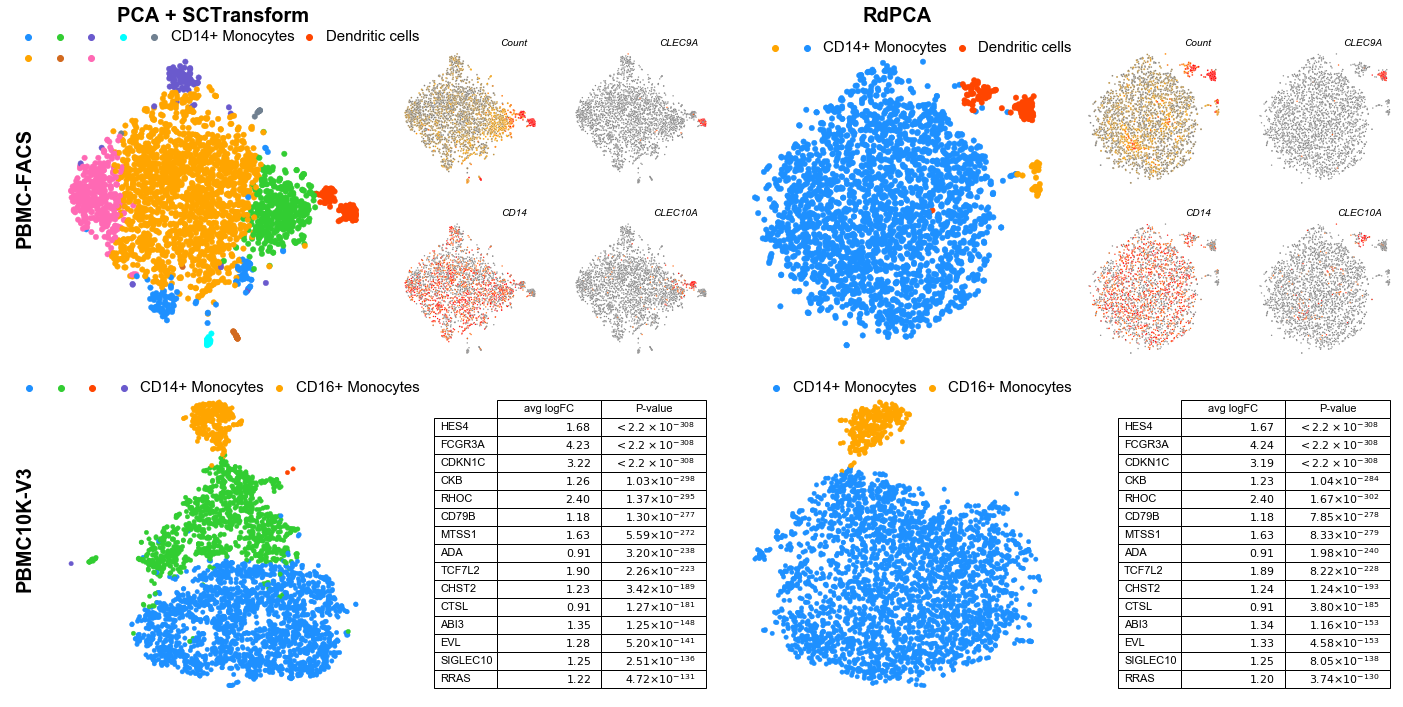

In [158]:
fig2 = plt.figure(figsize=(24, 12), constrained_layout=False) # 가로 세로
gs2 = fig2.add_gridspec(4, 8) #행렬
# fig 2c & 2d
fig2c = []
fig2c.append(fig2.add_subplot(gs2[0:2,0:2])) 
fig2c.append(fig2.add_subplot(gs2[0:1,2:3]))
fig2c.append(fig2.add_subplot(gs2[1:2,2:3]))
fig2c.append(fig2.add_subplot(gs2[0:1,3:4]))
fig2c.append(fig2.add_subplot(gs2[1:2,3:4]))
figure2_mid(fig2c, 'sct', 'fig2c')

# fig 2d
fig2d = []
fig2d.append(fig2.add_subplot(gs2[0:2,4:6])) 
fig2d.append(fig2.add_subplot(gs2[0:1,6:7]))
fig2d.append(fig2.add_subplot(gs2[1:2,6:7]))
fig2d.append(fig2.add_subplot(gs2[0:1,7:8]))
fig2d.append(fig2.add_subplot(gs2[1:2,7:8]))
figure2_mid(fig2d, 'rdpca', 'fig2c')


# fig 2e
fig2e = []
fig2e.append(fig2.add_subplot(gs2[2:4,0:2]))
fig2e.append(fig2.add_subplot(gs2[2:4,2:4]))
figure2_low(fig2e, 'sct', 'fig2e')


# fig 2f
fig2f = []
fig2f.append(fig2.add_subplot(gs2[2:4,4:6]))
fig2f.append(fig2.add_subplot(gs2[2:4,6:8]))
figure2_low(fig2f, 'rdpca', 'fig2e')

fig2c[0].text(-0.1, 0.55, 'PBMC-FACS', rotation=90, fontsize=20, fontweight='bold', ha='center', va='center', transform=fig2c[0].transAxes)
fig2e[0].text(-0.1, 0.55, 'PBMC10K-V3', rotation=90, fontsize=20, fontweight='bold', ha='center', va='center', transform=fig2e[0].transAxes)

fig2c[0].text(0.5, 1.1, 'PCA + SCTransform', fontsize=20, fontweight='bold', ha='center', va='center', transform=fig2c[0].transAxes)
fig2d[0].text(0.5, 1.1, 'RdPCA', fontsize=20, fontweight='bold', ha='center', va='center', transform=fig2d[0].transAxes)

plt.show()